In [1]:
from calliope.data import DataManager
from calliope.market import MeritOrderNEM, DataToBidObjInterface
import pandas as pd
import sqlite3
con = sqlite3.connect("E:\Code\Calliope/notebooks\historical_mms.db")
import datetime
data_manager = DataManager(con)
import matplotlib.pyplot as plt
import time
from nempy import markets

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

start_date = '2019/01/01 00:00:00'
end_date = '2019/02/01 00:00:00'
region = 'NSW1'


In [3]:
data_manager.load_data(start_date, end_date, region)

In [5]:
cost = {
    'regional_demand': 2175000.0, 
    'interocnnector': 16675000.0, 
    'generic_constraint': 435000.0, 
    'ramp_rate': 16747500.0, 
    'unit_capacity': 5365000.0, 
    'energy_offer': 16457500.0, 
    'fcas_profile': 2247500.0, 
    'fcas_max_avail': 2247500.0, 
    'fcas_enablement_min': 1015000.0, 
    'fcas_enablement_max': 1015000.0, 
    'fast_start': 16385000.0, 
    'mnsp_ramp_rate': 16747500.0, 
    'msnp_offer': 16457500.0, 
    'mnsp_capacity': 5292500.0, 
    'uigf': 5582500.0, 
    'voll': 14500.0,
    'tiebreak': 1e-06
}

aemo_to_nempy_service_name={
    'ENERGY': 'energy',
    'LOWER5MIN': 'lower_5min',
    'LOWER60SEC': 'lower_60s', 
    'LOWER6SEC': 'lower_6s', 
    'LOWERREG': 'lower_reg', 
    'RAISE5MIN': 'raise_5min',
    'RAISE60SEC': 'raise_60s', 
    'RAISE6SEC': 'raise_6s', 
    'RAISEREG': 'raise_reg'
}

dispatch_type_map = {
    'GENERATOR':'generator',
    'LOAD': 'load'

}

In [6]:
# Preprocessing up front to maximise time not used in dispatch
unit_info = data_manager.unit_mapping.copy()
unit_info.columns = ['unit', 'region', 'dispatch_type']
unit_info['region'] = 'NSW'
unit_info['dispatch_type'] = unit_info.apply(lambda x: dispatch_type_map[x.dispatch_type], axis=1)


# get bids
volume_bids = data_manager.volume_bids.copy()
price_bids = data_manager.price_bids.copy()

# get fcas trapeziums from bids
fcas_trapeziums = volume_bids.loc[volume_bids.BIDTYPE != 'ENERGY']

fcas_trapeziums = fcas_trapeziums[
    ['INTERVAL_DATETIME','DUID','BIDTYPE','MAXAVAIL','ENABLEMENTMIN','ENABLEMENTMAX','LOWBREAKPOINT','HIGHBREAKPOINT']
]
fcas_trapeziums.columns = [
    'INTERVAL_DATETIME','unit', 'service',
    'max_availability', 
    'enablement_min', 'enablement_max', 
    'low_break_point', 'high_break_point'
]
fcas_trapeziums['service'] = fcas_trapeziums.apply(lambda x: aemo_to_nempy_service_name[x.service], axis=1)


# bids to nempy format
volume_bids = volume_bids[['INTERVAL_DATETIME','DUID', 'BIDTYPE'] + [f'BANDAVAIL{i}' for i in range(1,11)]]
volume_bids.columns = ['INTERVAL_DATETIME', 'unit', 'service'] + [f'{i}' for i in range(1,11)]
volume_bids['service'] = volume_bids.apply(lambda x: aemo_to_nempy_service_name[x.service], axis=1)

price_bids = price_bids[['SETTLEMENTDATE','DUID', 'BIDTYPE']+[f'PRICEBAND{i}' for i in range(1,11)]]
price_bids.columns = ['SETTLEMENTDATE', 'unit', 'service'] + [f'{i}' for i in range(1,11)]
price_bids['service'] = price_bids.apply(lambda x: aemo_to_nempy_service_name[x.service], axis=1)

# get fcas requirements
fcas_requirements = data_manager.fcas_requirements

mapping = {
    'RAISEREG': ('NSW', 'raise_reg'),
    'LOWERREG': ('NSW', 'lower_reg'),
    'RAISE6SEC': ('NSW', 'raise_6s'),
    'RAISE60SEC': ('NSW', 'raise_60s'),
    'RAISE5MIN': ('NSW', 'raise_5min'),
    'LOWER6SEC': ('NSW', 'lower_6s'),
    'LOWER60SEC': ('NSW', 'lower_60s'),
    'LOWER5MIN': ('NSW', 'lower_5min')
}


# Demand
demand = data_manager.regional_demand.copy()
demand = demand[['SETTLEMENTDATE','REGIONID', 'TOTALDEMAND']]
demand.columns = ['SETTLEMENTDATE','region', 'demand']
demand['region'] = 'NSW'

In [21]:
energy_prices = pd.DataFrame()
fcas_prices = pd.DataFrame()

avg_total_time = 0
avg_dispatch_time = 0

for timestep in range(0, len(data_manager.dispatch_intervals)):
# for timestep in range(0, 100):
    
    # Initialise market outside
    market = markets.SpotMarket(
        unit_info=unit_info,
        market_regions=['NSW'])
    market.solver = 'GUROBI'

    total_time_i = time.time()
    di_curr = data_manager.dispatch_intervals[timestep]

    volume_bids_di = volume_bids.loc[volume_bids.INTERVAL_DATETIME == di_curr]
    volume_bids_di = volume_bids_di[volume_bids_di.columns[~volume_bids_di.columns.isin(['INTERVAL_DATETIME'])]]

    price_bids_di = price_bids.loc[
        price_bids.SETTLEMENTDATE == pd.to_datetime(di_curr.date() - datetime.timedelta(seconds=1))
    ]
    price_bids_di = price_bids_di[price_bids_di.columns[~price_bids_di.columns.isin(['SETTLEMENTDATE'])]]


    demand_di = demand.loc[demand.SETTLEMENTDATE == di_curr]
    demand_di = demand_di[demand_di.columns[~demand_di.columns.isin(['SETTLEMENTDATE'])]]



    # Create constraints that enforce the top of the FCAS trapezium.
    fcas_trapeziums_di = fcas_trapeziums.loc[fcas_trapeziums.INTERVAL_DATETIME == di_curr]
    fcas_trapeziums_di = fcas_trapeziums_di[fcas_trapeziums_di.columns[~fcas_trapeziums_di.columns.isin(['INTERVAL_DATETIME'])]]

    fcas_availability = fcas_trapeziums_di.loc[:, ['unit', 'service', 'max_availability']]


    fcas_requirements_di = fcas_requirements.loc[fcas_requirements.SETTLEMENTDATE == di_curr]
    fcas_requirements_di = fcas_requirements_di[fcas_requirements_di.columns[~fcas_requirements_di.columns.isin(['SETTLEMENTDATE'])]]

    # Create new DataFrame
    data = []
    for key, (region, service) in mapping.items():
        volume = list(fcas_requirements_di[key].values)[0]

        set = f'{region.lower()}_{service}_requirement'

        data.append({
            'set': set,
            'region': region,
            'service': service,
            'volume': volume,
            'type': '>='
        })

    fcas_requirements_di = pd.DataFrame(data)

    market.set_unit_volume_bids(volume_bids_di)
    market.set_unit_price_bids(price_bids_di)
    market.set_fcas_max_availability(fcas_availability)
    market.make_constraints_elastic('fcas_max_availability', cost['fcas_max_avail'])

    market.set_fcas_requirements_constraints(fcas_requirements_di)
    market.make_constraints_elastic('fcas', cost['fcas_profile'])

    market.set_demand_constraints(demand_di)

    contingency_trapeziums = fcas_trapeziums_di[~fcas_trapeziums_di['service'].isin(['raise_reg', 'lower_reg'])]
    market.set_joint_capacity_constraints(contingency_trapeziums)
    market.make_constraints_elastic('joint_capacity', cost['fcas_profile'])


    regulation_trapeziums = fcas_trapeziums_di[fcas_trapeziums_di['service'].isin(['raise_reg', 'lower_reg'])]
    market.set_energy_and_regulation_capacity_constraints(regulation_trapeziums)
    market.make_constraints_elastic('energy_and_regulation_capacity', cost['fcas_profile'])


    dispatch_time_i = time.time()
    market.dispatch()
    avg_dispatch_time = avg_dispatch_time + ((time.time() - dispatch_time_i) - avg_dispatch_time)/(timestep+1)
    avg_total_time = avg_total_time + ((time.time() - total_time_i) - avg_total_time)/(timestep+1)

    if not timestep % 12:
        print(f'At DI {di_curr}')
        print(f'\tAverage time for full iteration: {avg_total_time}')
        print(f'\tAverage time for market dispatch: {avg_dispatch_time}')

    # energy_prices = pd.concat([energy_prices, market.get_energy_prices()]).reset_index(drop=True)
    # fcas_prices = pd.concat([fcas_prices, market.get_fcas_prices()]).reset_index(drop=True)

Model infeasible attempting to find problem constraint.
Couldn't find an optimal solution, but removing con ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', 

ValueError: Linear program infeasible

In [42]:
import pandas as pd

from nempy import markets


# Set options so you see all DataFrame columns in print outs.

pd.options.display.width = 0

# Volume of each bid.

volume_bids = pd.DataFrame({

    'unit': ['A', 'A', 'B', 'B', 'B'],

    'service': ['energy', 'raise_6s', 'energy',

                'raise_6s', 'raise_reg'],

    '1': [100.0, 10.0, 110.0, 15.0, 15.0],  # MW

})



# Price of each bid.

price_bids = pd.DataFrame({

    'unit': ['A', 'A', 'B', 'B', 'B'],

    'service': ['energy', 'raise_6s', 'energy',

                'raise_6s', 'raise_reg'],

    '1': [50.0, 35.0, 60.0, 20.0, 30.0],  # $/MW

})


# Participant defined operational constraints on FCAS enablement.

fcas_trapeziums = pd.DataFrame({

    'unit': ['B', 'B', 'A'],

    'service': ['raise_reg', 'raise_6s', 'raise_6s'],

    'max_availability': [15.0, 15.0, 10.0],

    'enablement_min': [50.0, 50.0, 70.0],

    'low_break_point': [65.0, 65.0, 80.0],

    'high_break_point': [95.0, 95.0, 100.0],

    'enablement_max': [110.0, 110.0, 110.0]

})



# Unit locations.

unit_info = pd.DataFrame({

    'unit': ['A', 'B'],

    'region': ['NSW', 'NSW']

})



# The demand in the region\s being dispatched.

demand = pd.DataFrame({

    'region': ['NSW'],

    'demand': [195.0]  # MW

})



# FCAS requirement in the region\s being dispatched.

fcas_requirements = pd.DataFrame({

    'set': ['nsw_regulation_requirement', 'nsw_raise_6s_requirement'],

    'region': ['NSW', 'NSW'],

    'service': ['raise_reg', 'raise_6s'],

    'volume': [10.0, 10.0]  # MW
    

})

#                           set region    service  volume

# 0  nsw_regulation_requirement    NSW  raise_reg    10.0

# 1    nsw_raise_6s_requirement    NSW   raise_6s    10.0


# Create the market model with unit service bids.

market = markets.SpotMarket(unit_info=unit_info,
                            market_regions=['NSW'])
market.set_unit_volume_bids(volume_bids)
market.set_unit_price_bids(price_bids)
# Create constraints that enforce the top of the FCAS trapezium.
fcas_availability = fcas_trapeziums.loc[:, ['unit', 'service', 'max_availability']]
market.set_fcas_max_availability(fcas_availability)

# Create constraints that enforce the lower and upper slope of the FCAS regulation

# service trapeziums.

regulation_trapeziums = fcas_trapeziums[fcas_trapeziums['service'] == 'raise_reg']
market.set_energy_and_regulation_capacity_constraints(regulation_trapeziums)

# Create constraints that enforce the lower and upper slope of the FCAS contingency
# trapezium. These constrains also scale slopes of the trapezium to ensure the
# co-dispatch of contingency and regulation services is technically feasible.
contingency_trapeziums = fcas_trapeziums[fcas_trapeziums['service'] == 'raise_6s']
market.set_joint_capacity_constraints(contingency_trapeziums)


# Set the demand for energy.
market.set_demand_constraints(demand)

# Set the required volume of FCAS services.
market.set_fcas_requirements_constraints(fcas_requirements)

# Calculate dispatch and pricing
market.dispatch()





<Axes: >

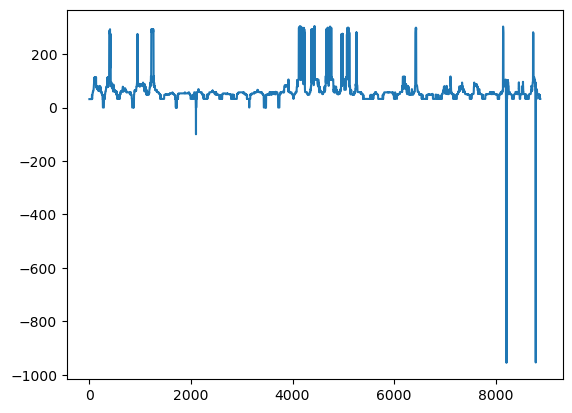

In [18]:
energy_prices.price.plot()

<Axes: >

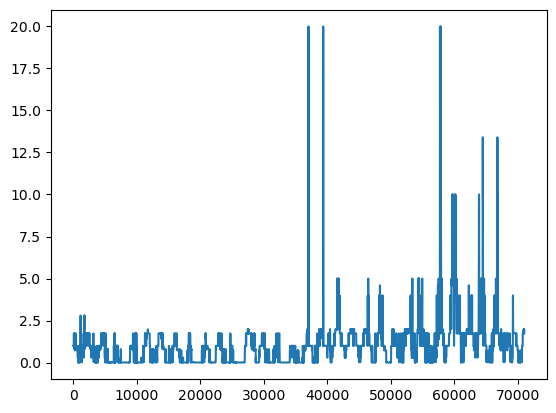

In [26]:
fcas_prices.loc[fcas_prices.service=='raise_6s'].price.plot()

In [6]:
nem = MeritOrderNEM(data_manager)
nem.build()
nem.load_bids_from_pickle('bid_dict_jan_nsw.pkl')

In [7]:
from calliope.market import MARKETS

prices = {m: [] for m in MARKETS}

# run thru and append market prices
i = 0
while not nem.terminated:
    i+=1

    if not i%288:
        print(f'DI {i}')
    nem.add_bids()
    dispatch = nem.dispatch()
    nem.step()
    for m in MARKETS:
        prices[m].append(dispatch[m]['price'])
    # print(dispatch['ENERGY']['price'])
    # print(dispatch['ENERGY']['demand'])
# dispatch['ENERGY']['dispatch']
    
nem.reset()

DI 288
DI 576
DI 864
DI 1152
DI 1440
DI 1728
DI 2016
DI 2304
DI 2592
DI 2880
DI 3168
DI 3456
DI 3744
DI 4032
DI 4320
DI 4608
DI 4896
DI 5184
DI 5472
DI 5760
DI 6048
DI 6336
DI 6624
DI 6912
DI 7200
DI 7488
DI 7776
DI 8064
DI 8352
DI 8640


In [25]:
print(dispatch['ENERGY']['winning_bids'][-1])

MACARTH1, 4: <-96.14,15.520000000000437>


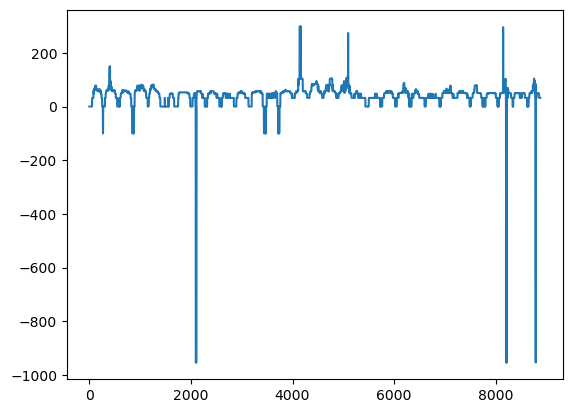

In [8]:
plt.plot(prices['ENERGY'])